### ay data need to be in the NetCDF before the debiasing the ACS chl
#### Note: this is based on the NASA HPLC xls file for AMT29

In [1]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal as sg
from datetime import datetime as dt

In [3]:
%matplotlib notebook

In [4]:
def prcrng(x):
    return (np.nanpercentile(x,84) - np.nanpercentile(x,16))/2.

In [5]:
DIN_hplc = "/data/datasets/cruise_data/active/AMT28/Optics_all/HPLC_DHI/"
DIN_acs = "/users/rsg/tjor/scratch_network/AMT_underway/AMT28/Processed/Underway/Step3/"

In [6]:
fn_hplc = "Results DAN_2019_012.xlsx"
fn_meta = "AMT28_HPLCsamples.xlsx"
fn_optics = "amt28_final.nc"

In [7]:
df_hplc = pd.read_excel(DIN_hplc + fn_hplc, sheet_name = "Sheet1", header = 2, engine = 'openpyxl', nrows=130)
df_hplc.keys()
# df_hplc

Index(['Date', 'SDY', 'Station', 'CTD', 'Label', 'Depth', 'Comments',
       'Volume ml', 'DHI no.', 'Chlorophyll c3', 'Chlorophyll c2',
       'Chlorophyll c1+MgDVP', 'Chlorophyllide a', 'Pheophorbide a',
       'Peridinin', '19-but-fucoxanthin', 'Fucoxanthin', 'Neoxanthin',
       'Prasinoxanthin', 'Violaxanthin', '19-Hex-fucoxanthin', 'Astaxanthin',
       'Diadinoxanthin', 'Myxoxanthophyll-like', 'Alloxanthin', 'Diatoxanthin',
       'Zeaxanthin', 'Lutein', 'Chl C2 MGDG', 'Chlorophyll b',
       'DV chlorophyll a', 'MV chlorophyll a', 'Pheophytin a', 'a-carotene',
       'b-carotene'],
      dtype='object')

In [8]:
df_meta = pd.read_excel(DIN_hplc + fn_meta, sheet_name = "HPLC data", header = 0, engine = 'openpyxl')
df_meta.keys()
# df_meta

Index(['Date', 'SDY', 'Station', 'CTD', 'Bottle', 'Time', 'Lat', 'Lon',
       'Replica', 'Volume', 'Label', 'Depth', 'Comments'],
      dtype='object')

In [9]:
# merge two tables to extract info from df_meta
df_hplc = pd.merge(df_hplc, df_meta, on=['Label'])
df_hplc.keys()

Index(['Date_x', 'SDY_x', 'Station_x', 'CTD_x', 'Label', 'Depth_x',
       'Comments_x', 'Volume ml', 'DHI no.', 'Chlorophyll c3',
       'Chlorophyll c2', 'Chlorophyll c1+MgDVP', 'Chlorophyllide a',
       'Pheophorbide a', 'Peridinin', '19-but-fucoxanthin', 'Fucoxanthin',
       'Neoxanthin', 'Prasinoxanthin', 'Violaxanthin', '19-Hex-fucoxanthin',
       'Astaxanthin', 'Diadinoxanthin', 'Myxoxanthophyll-like', 'Alloxanthin',
       'Diatoxanthin', 'Zeaxanthin', 'Lutein', 'Chl C2 MGDG', 'Chlorophyll b',
       'DV chlorophyll a', 'MV chlorophyll a', 'Pheophytin a', 'a-carotene',
       'b-carotene', 'Date_y', 'SDY_y', 'Station_y', 'CTD_y', 'Bottle', 'Time',
       'Lat', 'Lon', 'Replica', 'Volume', 'Depth_y', 'Comments_y'],
      dtype='object')

In [10]:
# convert DHI pigment names to NASA pigment names for submission
#                            DHI  :  NASA
dhi2nasa = {      "Chlorophyll c3":"Chl_c3",
#                 "Chlorophyll c2":"Chl c1c2", # these two successive pigments need to be merged (see below)
#           "Chlorophyll c1+MgDVP":"Chl c1c2",
                "Chlorophyllide a":"Chlide_a",
                  "Pheophorbide a":"Phide_a",
                       "Peridinin":"Perid",
              "19-but-fucoxanthin":"But-fuco",
                     "Fucoxanthin":"Fuco",
                      "Neoxanthin":"Neo",
                  "Prasinoxanthin":"Pras",
                    "Violaxanthin":"Viola",
              "19-Hex-fucoxanthin":"Hex-fuco",
                     "Astaxanthin":"DHI_only_Astaxanthin",
                  "Diadinoxanthin":"Diadino",
            "Myxoxanthophyll-like":"DHI_only_Myxoxanthophyll-like",
                     "Alloxanthin":"Allo",
                    "Diatoxanthin":"Diato",
                      "Zeaxanthin":"Zea",
                          "Lutein":"Lut",
                     "Chl C2 MGDG":"DHI_only_Chl_C2_MGDG",
                   "Chlorophyll b":"Tot_Chl_b",
                "DV chlorophyll a":"DV_Chl_a",
                "MV chlorophyll a":"MV_Chl_a",
                    "Pheophytin a":"Phytin_a"}
#                     "a-carotene":"Alpha-beta-Car", # these two successive pigments need to be merged (see below)
#                     "b-carotene":"Alpha-beta-Car"}

# rename DHI columns with NASA names
df_hplc = df_hplc.rename(columns = dhi2nasa)

# create merged pigments
# "Alpha-beta-Car", 
df_hplc["Alpha-beta-Car"] = df_hplc["a-carotene"] + df_hplc["b-carotene"]
df_hplc = df_hplc.drop(columns=["a-carotene", "b-carotene"])
           
# "Chl c1c2"
df_hplc["Chl_c1c2"] = df_hplc["Chlorophyll c2"] + df_hplc["Chlorophyll c1+MgDVP"]
df_hplc = df_hplc.drop(columns=["Chlorophyll c2", "Chlorophyll c1+MgDVP"])

# "Tot_Chl_a" = DV_Chl_a + MV_Chl_a + Chlide_a (+ Chl_a allomers + Chl_a epimers)
df_hplc["Tot_Chl_a"] = df_hplc["DV_Chl_a"] + df_hplc["MV_Chl_a"] + df_hplc["Chlide_a"]

# "Tot_Chl_c" = Tot_Chl_a + Tot_Chl_b + Tot_Chl_c
df_hplc["Tot_Chl_c"] = df_hplc["Chl_c3"] + df_hplc["Chl_c1c2"]

# "Tchl" = Tot_Chl_a + Tot_Chl_b + Tot_Chl_c
df_hplc["Tchl"] = df_hplc["Tot_Chl_a"] + df_hplc["Tot_Chl_b"] + df_hplc["Tot_Chl_c"]

# "PPC" (photoprotective carotenoids) = allo + diadino + diato + zea + alpha-beta-car)
df_hplc["PPC"] = df_hplc["Allo"] + df_hplc["Diadino"] + df_hplc["Diato"] + df_hplc["Zea"] + df_hplc["Alpha-beta-Car"]

# "PSC" (photosynthetic carotenoids) = but-fuco + fuco + hex-fuco + perid)
df_hplc["PSC"] = df_hplc["But-fuco"] + df_hplc["Fuco"] + df_hplc["Hex-fuco"] + df_hplc["Perid"] 

# "PSP" (phosynthetic pigments) = PSC + TChl
df_hplc["PSP"] = df_hplc["PSC"] + df_hplc["Tchl"] 

# "Tcar" (total carotenoids) = PPC + PSC
df_hplc["Tcar"] = df_hplc["PPC"] + df_hplc["PSC"] 

# "Tacc" (total accessory pigments) = PPC + PSC + Tot_Chl_b + Tot_Chl_c 
df_hplc["Tacc"] = df_hplc["PPC"] + df_hplc["PSC"] + df_hplc["Tot_Chl_b"] + df_hplc["Tot_Chl_c"] 

# "Tpg" (total pigments) = TAcc + Tot_Chl_a
df_hplc["Tpg"] = df_hplc["Tacc"] + df_hplc["Tot_Chl_a"] 

# "DP" (total diagnostic pigments) = PSC + allo + zea + Tot_Chl_b
df_hplc["DP"] = df_hplc["PSC"] + df_hplc["Allo"] + df_hplc["Zea"] + df_hplc["Tot_Chl_b"]


# new dictionary with additional pigments
derived_pigs = {"Alpha-beta-Car":"Alpha-beta-Car",
                "Chl_c1c2":"Chl_c1c2",
                "Tot_Chl_a":"Tot_Chl_a",
                "Tot_Chl_c":"Tot_Chl_c",
                "Tchl":"Tchl",
                "PPC":"PPC",
                "PSC":"PSC",
                "PSP":"PSP",
                "Tcar":"Tcar",
                "Tacc":"Tacc",
                "Tpg":"Tpg",
                "DP":"DP"      }

# df_hplc.keys()



In [11]:
# merge dictonaries with names of all pigments
all_pigs = dict(dhi2nasa, **derived_pigs)

In [12]:
# find matching keys and merge them into a single one
for key in df_hplc.keys():
    if "_x" in key:
        print(key)
        if ~(np.all(df_hplc[key] == df_hplc[key[:-1]+"y"])):
            print([key, " not matching"])
        else:
            # drop *_x key
            print(["droppping " + key ])
            df_hplc = df_hplc.drop(columns = [key])
            # rename *_y key
            print(["renaming " + key ])
            df_hplc = df_hplc.rename(columns = {key[:-1]+"y" : key[:-2]})
            

Date_x
['droppping Date_x']
['renaming Date_x']
SDY_x
['droppping SDY_x']
['renaming SDY_x']
Station_x
['droppping Station_x']
['renaming Station_x']
CTD_x
['droppping CTD_x']
['renaming CTD_x']
Depth_x
['droppping Depth_x']
['renaming Depth_x']
Comments_x
['Comments_x', ' not matching']


In [13]:
# convert date (numpy.datetime64) and time (datetime.time) to a single datetime object
from datetime import datetime as dt

# convert date from (numpy.datetime64) to (datetime.time) 
ts = (df_hplc.Date - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
newts = [dt.utcfromtimestamp(tsi) for tsi in ts]

# add Time object to Date object to get DateTime object
mydatetime = [dt.combine(newts[i], df_hplc.Time.values[i]) for i,j in enumerate(df_hplc.Time)  ]

# create "Time" key in df_hplc
df_hplc['time'] = mydatetime

# drop Date and Time
df_hplc = df_hplc.drop(columns = ["Date", "Time"])
                       
df_hplc = df_hplc.sort_values(by = ['time'])
df_hplc = df_hplc.reset_index(drop = True)

df_hplc.keys()

/tmp/ipykernel_1130618/2404252306.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  ts = (df_hplc.Date - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Index(['Label', 'Comments_x', 'Volume ml', 'DHI no.', 'Chl_c3', 'Chlide_a',
       'Phide_a', 'Perid', 'But-fuco', 'Fuco', 'Neo', 'Pras', 'Viola',
       'Hex-fuco', 'DHI_only_Astaxanthin', 'Diadino',
       'DHI_only_Myxoxanthophyll-like', 'Allo', 'Diato', 'Zea', 'Lut',
       'DHI_only_Chl_C2_MGDG', 'Tot_Chl_b', 'DV_Chl_a', 'MV_Chl_a', 'Phytin_a',
       'SDY', 'Station', 'CTD', 'Bottle', 'Lat', 'Lon', 'Replica', 'Volume',
       'Depth', 'Comments_y', 'Alpha-beta-Car', 'Chl_c1c2', 'Tot_Chl_a',
       'Tot_Chl_c', 'Tchl', 'PPC', 'PSC', 'PSP', 'Tcar', 'Tacc', 'Tpg', 'DP',
       'time'],
      dtype='object')

In [14]:
# clean up lat
tmpla = df_hplc['Lat'].values
for i,la in enumerate(tmpla):
    if (type(la) != float) & (type(la) != int):
#         print(type(la))
#         print(i, "    ", la)
        # assume the string is similar to "31°31.784'W"
        
        # replace "º" by "°"
        la = la.replace("º", "°")
        
        degrees = float(la.split("°")[0]) 
        minutes = float(la.split("°")[-1].split("'")[0])
        NoS = la.split("°")[-1].split("'")[-1]
        sign = -1
        if (NoS.upper() == "N"):
            sign = 1
        df_hplc.at[i, 'Lat'] = sign*(degrees + minutes/60.)

# clean up lon
tmplo = df_hplc['Lon'].values
for i,lo in enumerate(tmplo):
    if (type(lo) != float) & (type(lo) != int):
#         print(type(lo))
#         print(i, "    ", lo)
        # assume the string is similar to "31°31.784'"
        
        # replace "º" by "°"
        lo = lo.replace("º", "°")
        
        degrees = float(lo.split("°")[0]) 
        minutes = float(lo.split("°")[-1].split("'")[0])
        EoW = lo.split("°")[-1].split("'")[-1]
        sign = -1
        if (EoW.upper() == "E"):
            sign = 1
        df_hplc.at[i, 'Lon'] = sign*(degrees + minutes/60.)

print(df_hplc['Lat'])


0      49.638117
1      48.469367
2      47.901233
3      47.901233
4      47.360167
         ...    
123     -46.6331
124   -47.561817
125   -47.561817
126   -48.198867
127   -48.198867
Name: Lat, Length: 128, dtype: object


In [15]:
# extract surface data

# replace UND label with nominal depth of rUNDerway measurements
df_hplc.Depth[df_hplc.Depth=="UND"] = 7

isurf = df_hplc["Depth"]<10
df_hplc_surf = df_hplc[isurf]
df_hplc_surf = df_hplc_surf.set_index("time")
df_hplc_surf



/tmp/ipykernel_1130618/3026277751.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hplc.Depth[df_hplc.Depth=="UND"] = 7


,Label,Comments_x,Volume ml,DHI no.,Chl_c3,Chlide_a,Phide_a,Perid,But-fuco,Fuco,...,Tot_Chl_a,Tot_Chl_c,Tchl,PPC,PSC,PSP,Tcar,Tacc,Tpg,DP
time,,,,,,,,,,,,,,,,,,,,,
2018-09-25 12:35:00,H001C,NaN,2000,63,0.116,0.112,0.0,0.995,0.031,0.196,...,2.947,0.630,3.766,0.578,1.425,5.191,2.003,2.822,5.769,1.724
2018-09-26 03:34:00,H005C,NaN,2000,64,0.063,0.016,0.0,0.011,0.050,0.064,...,0.392,0.067,0.480,0.042,0.226,0.706,0.268,0.356,0.748,0.258
2018-09-26 12:10:00,H009C,NaN,2000,65,0.088,0.010,0.0,0.011,0.110,0.035,...,0.520,0.170,0.713,0.050,0.395,1.108,0.445,0.638,1.158,0.450
2018-09-26 12:50:00,H013UND,NaN,2000,1,0.091,0.009,0.0,0.015,0.110,0.037,...,0.520,0.179,0.718,0.111,0.407,1.125,0.518,0.716,1.236,0.456
2018-09-26 18:53:00,H014UND,NaN,2000,2,0.109,0.013,0.0,0.021,0.129,0.034,...,0.706,0.227,0.959,0.129,0.523,1.482,0.652,0.905,1.611,0.597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-26 20:50:00,H305UND,NaN,3000,61,0.049,0.029,0.0,0.056,0.035,0.064,...,0.627,0.125,0.894,0.113,0.254,1.148,0.367,0.634,1.261,0.434
2018-10-27 06:37:00,H306C,NaN,3000,124,0.056,0.024,0.0,0.062,0.037,0.081,...,0.701,0.143,0.998,0.108,0.289,1.287,0.397,0.694,1.395,0.484
2018-10-27 06:37:00,H308C,NaN,3000,125,0.037,0.009,0.0,0.040,0.024,0.054,...,0.476,0.093,0.675,0.065,0.187,0.862,0.252,0.451,0.927,0.318


In [16]:
# read ACS data
fn_acs = fn_optics
acs = xr.open_dataset(DIN_acs+fn_acs)
acs.close()


# replace uway_long with uway_lon
if "uway_long" in acs.keys():
    acs.uway_lon = acs.uway_long
    acs = acs.drop(labels="uway_long")

acs

list(acs.keys())

['flow',
 'acs_chl',
 'acs_ap',
 'acs_ap_u',
 'acs_bp',
 'acs_bp_u',
 'acs_cp',
 'acs_cp_u',
 'acs_N',
 'ac9_chl',
 'ac9_ap',
 'ac9_ap_u',
 'ac9_bp',
 'ac9_bp_u',
 'ac9_cp',
 'ac9_cp_u',
 'ac9_N',
 'ac9_chl_adj',
 'bb3_bbp',
 'bb3_bbp_err',
 'bb3_bb02',
 'bb3_bb02_err',
 'bb3_bbp_corr',
 'cstar_cp',
 'cstar_cp_err',
 'ctd_sst',
 'ctd_sal',
 'uway_lat',
 'uway_lon',
 'uway_air_temp1',
 'uway_humidity1',
 'uway_par',
 'uway_tir1',
 'uway_air_temp2',
 'uway_humidity2',
 'uway_par2',
 'uway_tir2',
 'uway_baro1',
 'uway_baro2',
 'uway_thermosalinograph_temp',
 'uway_conductivity',
 'uway_sal',
 'uway_velocity',
 'uway_chl',
 'uway_sample_temp',
 'uway_flowrate',
 'uway_sst',
 'uway_field28th',
 'uway_field29th']

In [17]:
# fig, ax = plt.subplots(2,1, figsize=[12,6], sharex=True)
# ax[0].plot(acs.time, acs.uway_lon, '.')
# ax[1].plot(acs.time, acs.uway_lat, '.')


In [18]:
# 

### Add HPLC data to NetCDF file

In [19]:
# convert to lower case some keys in hplc dataframe
if "Lon" in  df_hplc_surf:
    df_hplc_surf = df_hplc_surf.rename(columns = {"Lon":"lon"})
if "Lat" in  df_hplc_surf:
    df_hplc_surf = df_hplc_surf.rename(columns = {"Lat":"lat"})
if "Time" in  df_hplc_surf:
    df_hplc_surf = df_hplc_surf.rename(columns = {"Time":"time"})
if "Depth" in  df_hplc_surf:
    df_hplc_surf = df_hplc_surf.rename(columns = {"Depth":"depth"})


In [20]:
df_hplc_surf.keys()

Index(['Label', 'Comments_x', 'Volume ml', 'DHI no.', 'Chl_c3', 'Chlide_a',
       'Phide_a', 'Perid', 'But-fuco', 'Fuco', 'Neo', 'Pras', 'Viola',
       'Hex-fuco', 'DHI_only_Astaxanthin', 'Diadino',
       'DHI_only_Myxoxanthophyll-like', 'Allo', 'Diato', 'Zea', 'Lut',
       'DHI_only_Chl_C2_MGDG', 'Tot_Chl_b', 'DV_Chl_a', 'MV_Chl_a', 'Phytin_a',
       'SDY', 'Station', 'CTD', 'Bottle', 'lat', 'lon', 'Replica', 'Volume',
       'depth', 'Comments_y', 'Alpha-beta-Car', 'Chl_c1c2', 'Tot_Chl_a',
       'Tot_Chl_c', 'Tchl', 'PPC', 'PSC', 'PSP', 'Tcar', 'Tacc', 'Tpg', 'DP'],
      dtype='object')

In [21]:
# create hplc_time coordinate
acs = acs.assign_coords(coords={'hplc_time' : (['hplc_time'], df_hplc_surf.index, {'time zone' : 'UTC'}) })
acs.hplc_time.encoding['units'] = "seconds since 1970-01-01 00:00:00"
acs.hplc_time.encoding['calendar'] = "proleptic_gregorian"


In [22]:
# #### read HPLC metadata on pigments (if NASA)
# hplc_pignm = pd.read_excel(DIN_hplc + fn_hplc, sheet_name = "information", header = 4, engine = 'openpyxl',
#                         nrows = 38, usecols = [1, 3, 4, 12, 13, 14], dtype=str)

# # shift info around in original table
# df1 = hplc_pignm.iloc[:, [0,1,2]]
# df2 = hplc_pignm.iloc[:, [3,4,5]] 
# df2 = df2.rename(columns={ df2.keys()[0]: 'abbreviation',
#                      df2.keys()[1]: 'name',
#                      df2.keys()[2]: 'notes'
#                     })
# df1 = df1.rename(columns={ df1.keys()[0]: 'abbreviation',
#                      df1.keys()[1]: 'name',
#                      df1.keys()[2]: 'notes'
#                     })
# # concatenate to subsets of attributes
# df1 = df1.append(df2, ignore_index=True)

# # find indices with empty abbreviations and drop them
# ind = []
# for irow in range(len(df1['abbreviation'].values)):
#     if type(df1['abbreviation'].values[irow])==float:
#         ind.append(irow)
    
# df_hplc_pignm = df1.drop(ind)    


In [23]:
# df_hplc.plot.scatter(x='lat', y='DV_Chl_b', xlim=(-60,60), ylim=(0,0.3), marker='o', grid='on', alpha=0.5)

In [24]:
### add HPLC variables to acs dataset
# drop time-related columns
if 'year' in df_hplc_surf.keys():
    df_hplc_surf = df_hplc_surf.drop(columns=['year', 'month', 'day', 'sdy',
                               'water_depth', 'name of water body' ])
df_hplc_surf.keys()

Index(['Label', 'Comments_x', 'Volume ml', 'DHI no.', 'Chl_c3', 'Chlide_a',
       'Phide_a', 'Perid', 'But-fuco', 'Fuco', 'Neo', 'Pras', 'Viola',
       'Hex-fuco', 'DHI_only_Astaxanthin', 'Diadino',
       'DHI_only_Myxoxanthophyll-like', 'Allo', 'Diato', 'Zea', 'Lut',
       'DHI_only_Chl_C2_MGDG', 'Tot_Chl_b', 'DV_Chl_a', 'MV_Chl_a', 'Phytin_a',
       'SDY', 'Station', 'CTD', 'Bottle', 'lat', 'lon', 'Replica', 'Volume',
       'depth', 'Comments_y', 'Alpha-beta-Car', 'Chl_c1c2', 'Tot_Chl_a',
       'Tot_Chl_c', 'Tchl', 'PPC', 'PSC', 'PSP', 'Tcar', 'Tacc', 'Tpg', 'DP'],
      dtype='object')

In [25]:
## for NASA only
# df_hplc_pignm.abbreviation.values

In [26]:
# if NASA

# # find names of hplc vars
# hplc_cols = df_hplc_surf.keys()
# #add attributes to each variable and add it to acs xr dataset
# _var = ()
# _attrs = {}
# for ivar in hplc_cols:
# #     print(ivar)
#     lbl = ivar.replace(" ", "_").replace("__", "_") # repalce spaces with _
#     print(lbl)
    
#     if 'diameter' in ivar:
#         lbl = lbl[:-5]
#         _attrs = {'units': 'mm'}
#         _var = (['hplc_time'], df_hplc[ivar] ) 
    
#     elif lbl in df_hplc_pignm['abbreviation'].values:
#         # find index of df_hplc_pignm ivar
#         ik = list(df_hplc_pignm['abbreviation']).index(lbl)
# #         print("^^^^^^^^^^^this is a pigment")
#         _attrs = {'units' : 'mg/m3',
#                   'full_pigment_name' : df_hplc_pignm['name'].values[ik],
#                   'notes' : df_hplc_pignm['notes'].values[ik]}
#         _var = (['hplc_time'], df_hplc[ivar])
# #             print(_var)
#     else:
# #         print('nothing to do: ' + ivar)
#         _attrs = {}
#         _var = (['hplc_time'], df_hplc[ivar]) 
        
        
#     acs['hplc_'+lbl] = _var
#     acs['hplc_'+lbl].attrs = _attrs
    
#     # reset _var and _attrs
#     _var = ()
#     _attras = {}
    
# #     print(lbl)


# ## HOW TO CHECK THAT ALL PIGMENTS HAVE HAD THEIR ATTRIBUTES?

In [27]:
pigs_names = {value:key for key, value in all_pigs.items()} 
# pigs_names

In [28]:
# find names of hplc vars
hplc_cols = df_hplc_surf.keys()
#add attributes to each variable and add it to acs xr dataset
_var = ()
_attrs = {}
for ivar in hplc_cols:
#     print(ivar)
    lbl = ivar.replace(" ", "_").replace("__", "_") # repalce spaces with _

    
    if 'diameter' in ivar:
        lbl = lbl[:-5]
        _attrs = {'units': 'mm'}
        _var = (['hplc_time'], df_hplc_surf[ivar] ) 
        acs['hplc_'+lbl.lower()] = _var
        acs['hplc_'+lbl.lower()].attrs = _attrs
#         print(["NOT A PIGM: "+lbl.lower()])
        
    elif lbl in pigs_names.keys():
#         print("^^^^^^^^^^^this is a pigment")
        _attrs = {'units' : 'mg/m3'}
        _var = (['hplc_time'], df_hplc_surf[ivar])
#             print(_var)
        acs['hplc_'+lbl] = _var
        acs['hplc_'+lbl].attrs = _attrs
#         print(lbl)
        
    else:
#         print('nothing to do: ' + ivar)
        _attrs = {}
        _var = (['hplc_time'], df_hplc_surf[ivar]) 
        acs['hplc_'+lbl.lower()] = _var
        acs['hplc_'+lbl.lower()].attrs = _attrs
#         print(["NOT A PIGM: "+lbl.lower()])
        
    
    # reset _var and _attrs
    _var = ()
    _attras = {}
    
#     print(lbl)


## HOW TO CHECK THAT ALL PIGMENTS HAVE HAD THEIR ATTRIBUTES?

In [29]:
# var = 'hplc_filter_storage_before_shipment_to_GFC'
# ty = [type(acs[var].values[i]) for i,tmp in enumerate(acs[var].values)]

# if ~np.all([ty[i]==ty[0] for i,tmp in enumerate(ty)]):
#     print(ty)


In [30]:
"hplc_ctd" in acs.keys()

True

In [31]:
# ensure that hplc_variables with text and numbers in are arrays of strings
if "hplc_comments" in acs.keys():
    new_comments = [str(acs.hplc_comments.values[i]) for i in range(len(acs.hplc_comments.values))]
    acs['hplc_comments'] = (['hplc_time'], new_comments)

if "hplc_comments_x" in acs.keys():
    new_comments = [str(acs.hplc_comments_x.values[i]) for i in range(len(acs.hplc_comments_x.values))]
    acs['hplc_comments_x'] = (['hplc_time'], new_comments)

if "hplc_comments_y" in acs.keys():
    new_comments = [str(acs.hplc_comments_y.values[i]) for i in range(len(acs.hplc_comments_y.values))]
    acs['hplc_comments_y'] = (['hplc_time'], new_comments)

if "hplc_station" in acs.keys():
    new_st = [str(acs.hplc_station.values[i]) for i in range(len(acs.hplc_station.values))]
    acs['hplc_station'] = (['hplc_time'], new_st)

if "hplc_ctd" in acs.keys():
    new_st = [str(acs.hplc_ctd.values[i]) for i in range(len(acs.hplc_ctd.values))]
    acs['hplc_ctd'] = (['hplc_time'], new_st)

new_btl = [str(acs.hplc_bottle.values[i]) for i in range(len(acs.hplc_bottle.values))]
acs['hplc_bottle'] = (['hplc_time'], new_btl)

for ikey in acs.keys():
    if 'hplc' not in ikey:
        continue
    acs[ikey].dtype

In [32]:
# add extra metadata
acs['hplc_file'] = fn_hplc

In [33]:
# fig, ax = plt.subplots(1)
# ax.scatter(acs['hplc_lat'].values, acs['hplc_Diato'].values, marker='o', alpha=0.5)
# ax.set_xlim([-60, 60])
# ax.set_ylim([0, 0.06])
# ax.grid('on', ls='--')

In [34]:
# fig, ax = plt.subplots(1, figsize=(10, 4))
# # ax.plot(acs.time, acs.acs_chl/acs.acs_ap[:,acs.wv==490], 'k.', lw=0.5, ms=1, alpha=0.5)
# ax.plot(acs.time, acs.ay_slope, 'r.', lw=0.5, ms=1)
# ax.plot(acs.time, acs.cy_slope, 'k.', lw=0.5, ms=1)
# ax.grid('on', ls='--', lw=0.5)

In [35]:
acs['acs_chl'].attrs

{'acs_chl_units': 'mg/m3',
 'acs_chl_equation': 'chla = (acs.ap(:,wv676)-39/65.*acs.ap(:,wv650)-26/65*acs.ap(:,wv714))./0.014;',
 'acs_chl_comment': 'uncalibrated, not-debiased chl estimated from ACS ap'}

/tmp/ipykernel_1130618/3408017591.py:2: RuntimeWarning: Mean of empty slice
  acs["acx_chl"] = (['time'], np.nanmean(np.asarray([acs['ac9_chl_adj'].values, acs['acs_chl'].values]), axis=0) )


<IPython.core.display.Javascript object>


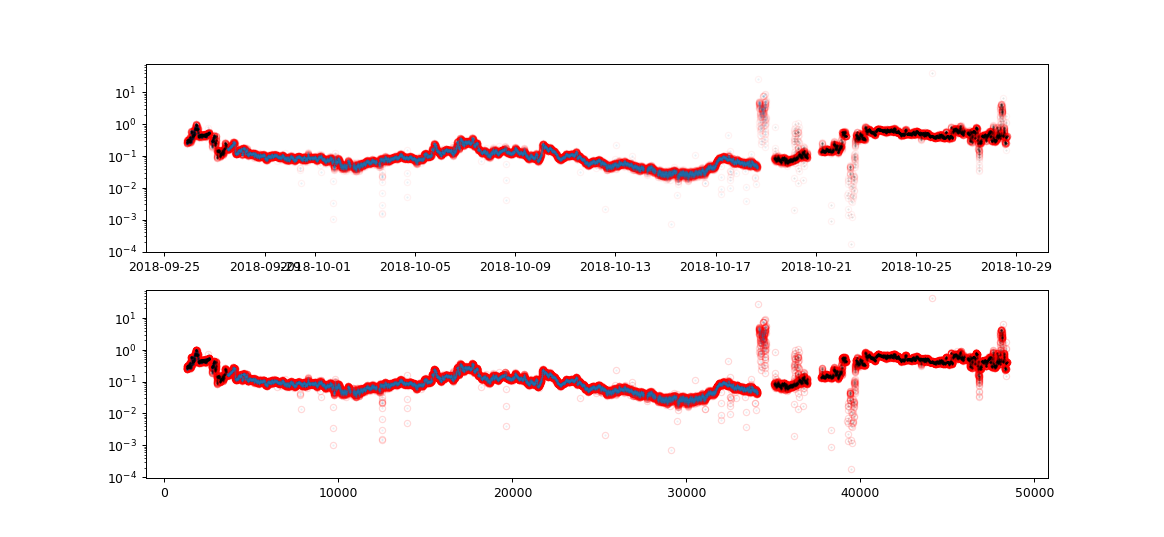

In [36]:
# create acx_chl variable that merges the ac9_chl and acs_chl if available
acs["acx_chl"] = (['time'], np.nanmean(np.asarray([acs['ac9_chl_adj'].values, acs['acs_chl'].values]), axis=0) )
acs["acx_chl"].attrs = {"acx_chl_units":"mg/m3",
                       "acx_chl_comment":"merged the ac9_chl and acs_chl",
                       }

# plot it
fig,ax = plt.subplots(2,1, figsize=[13,6])
ax[0].semilogy(acs.time, acs.acx_chl, 'ro', lw=0.5, ms=5, mfc='none', alpha=0.05)
ax[0].semilogy(acs.time, acs.acs_chl, '.', lw=0.5, ms=1, mfc='none', alpha=0.15)
ax[0].semilogy(acs.time, acs.ac9_chl_adj, 'k.', lw=0.5, ms=1, mfc='none', alpha=0.15)

ax[1].semilogy(np.arange(len(acs.time)), acs.acx_chl, 'ro', lw=0.5, ms=5, mfc='none', alpha=0.15)
ax[1].semilogy(np.arange(len(acs.time)), acs.acs_chl, '.', lw=0.5, ms=1, mfc='none', alpha=0.15)
ax[1].semilogy(np.arange(len(acs.time)), acs.ac9_chl_adj, 'k.', lw=0.5, ms=1, mfc='none', alpha=0.15)

In [37]:
acs

<xarray.Dataset>
Dimensions:                             (time: 48960, acs_wv: 176, ac9_wv: 9,
                                         bb3_wv: 3, hplc_time: 124)
Coordinates:
  * time                                (time) datetime64[ns] 2018-09-25 ... ...
  * acs_wv                              (acs_wv) float64 400.0 402.0 ... 750.0
  * ac9_wv                              (ac9_wv) float64 412.0 440.0 ... 715.0
  * bb3_wv                              (bb3_wv) float64 470.0 532.0 700.0
  * hplc_time                           (hplc_time) datetime64[ns] 2018-09-25...
Data variables: (12/99)
    flow                                (time) float64 ...
    acs_chl                             (time) float64 nan nan nan ... nan nan
    acs_ap                              (time, acs_wv) float64 ...
    acs_ap_u                            (time, acs_wv) float64 ...
    acs_bp                              (time, acs_wv) float64 ...
    acs_bp_u                            (time, acs_wv) float64 ...
    ...                                  ...
    hplc_Tcar                           (hplc_time) float64 2.003 ... 0.283
    hplc_Tacc                           (hplc_time) float64 2.822 0.356 ... 0.48
    hplc_Tpg                            (hplc_time) float64 5.769 0.748 ... 0.95
    hplc_DP                             (hplc_time) float64 1.724 ... 0.321
    hplc_file                           <U25 'Results DAN_2019_012.xlsx'
    acx_chl                             (time) float64 nan nan nan ... nan nan

In [38]:
# manually identify (using plot above) noisy parts of the acx_chl timeseries
i2rm = [  [34104, 35027], # start and end index of noisy period 1
          [39190, 39714],  # start and end index of noisy period 2
          [46767, 46861]  # start and end index of noisy period 3
       ]

# set values to nan inside the above intervals
for istart,tmp in enumerate(i2rm):
#     print(istart, tmp[0], tmp[1])
    acs['acx_chl'].values[tmp[0]:tmp[1]] = np.nan
    acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs_ap_u'].values[tmp[0]:tmp[1], :] = np.nan


<IPython.core.display.Javascript object>


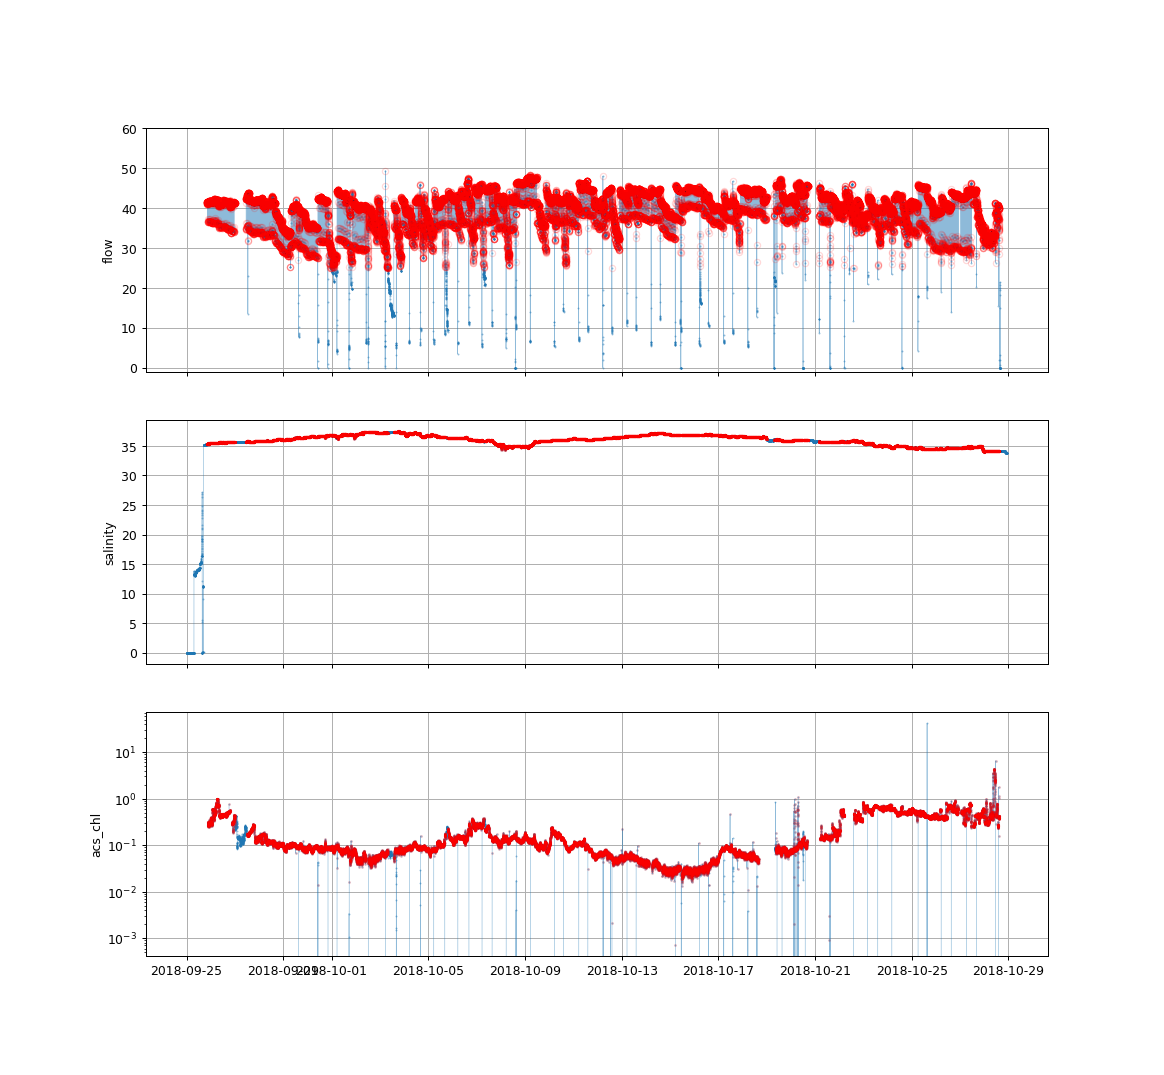

In [39]:
# filter acs data for MQ and noisy events
MIN_FLOW_RATE = 25
MIN_SAL = 33

i2f = np.where(  (acs.flow>MIN_FLOW_RATE) & (acs.uway_sal>MIN_SAL)   )[0]

fig, ax = plt.subplots(3,1, figsize=(13, 12), sharex=True)
ax[0].plot(acs.time, acs.flow, '.-', lw=0.5, ms=1, alpha=0.5)
ax[0].plot(acs.time[i2f], acs.flow[i2f], 'ro', lw=0.5, ms=5, mfc='none', alpha=0.15)
ax[0].set_ylabel('flow')
ax[0].grid('on')
ax[0].set_ylim([-1, 60])

# fig0, ax0 = plt.subplots(1, figsize=(15, 5))
ax[1].plot(acs.time, acs.uway_sal, '.-', lw=0.5, ms=1, alpha=0.5)
ax[1].plot(acs.time[i2f], acs.uway_sal[i2f], 'r.', lw=0.1, ms=3, mfc='none', alpha=0.15)
ax[1].set_ylabel('salinity')
ax[1].grid('on')

# fig2, ax2 = plt.subplots(1, figsize=(15, 5))
ax[2].semilogy(acs.time, acs.acx_chl, '.-', lw=0.5, ms=1, alpha=0.5)
ax[2].semilogy(acs.time[i2f], acs.acx_chl[i2f], 'r.', lw=0.1, ms=3, mfc='none', alpha=0.15)
ax[2].set_ylabel('acs_chl')
ax[2].grid('on')
# plt.ylim([1e-6, 10])


In [40]:
df_UND = df_hplc_surf.loc[(df_hplc_surf['CTD'] == "UND") & (df_hplc_surf['Bottle'] == "UND")]
df_CTD = df_hplc_surf.loc[(df_hplc_surf['CTD'] != "UND") & (df_hplc_surf['Bottle'] != "UND")]

<IPython.core.display.Javascript object>


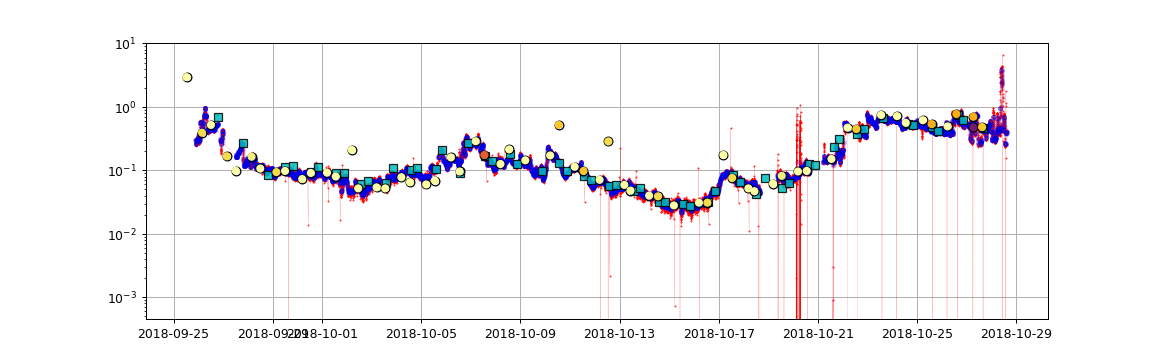

In [41]:
# median filter data
MEDFILT_WIN = 31

innan = np.where(~np.isnan(acs.acx_chl[i2f]))[0] # need to remove nans to prevent medfilt to be spiky near edges

fig2, ax2 = plt.subplots(1, figsize=(13, 4))
ax2.semilogy(acs.time[i2f][innan], acs.acx_chl[i2f][innan], 'r.-', lw=0.1, ms=1, mfc='none')
ax2.semilogy(acs.time[i2f][innan], sg.medfilt(acs.acx_chl[i2f][innan], kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=3, mfc='none', alpha = 0.05)
ax2.grid('on')
# plt.ylim([1e-6, 10])


#ax2.semilogy(acs.hplc_time, acs.hplc_pigs_Tot_Chl_a, 'go', ms=5, alpha=1)#, mfc='none')
ax2.semilogy(df_CTD.index, df_CTD.Tot_Chl_a, 'ko', ms=7, alpha=1, mfc='none', zorder=60)
ax2.scatter(df_CTD.index, df_CTD.Tot_Chl_a, c=df_CTD.Bottle.values, s=30, alpha=1, zorder=60, cmap = plt.get_cmap('inferno'), vmin=2, vmax=24)
ax2.semilogy(df_UND.index, df_UND.Tot_Chl_a, 'ks', ms=7, alpha=0.85, mfc='c')


# acs chl needs re-defining here
#acs['acx_chl'] = sg.medfilt(acs.acx_chl[i2f][innan], kernel_size=MEDFILT_WIN)

In [42]:
len(acs['acx_chl'].values )


#sg.medfilt(acs.acx_chl[i2f][innan], kernel_size=MEDFILT_WIN)

48960

In [43]:
df_CTD.keys()



Index(['Label', 'Comments_x', 'Volume ml', 'DHI no.', 'Chl_c3', 'Chlide_a',
       'Phide_a', 'Perid', 'But-fuco', 'Fuco', 'Neo', 'Pras', 'Viola',
       'Hex-fuco', 'DHI_only_Astaxanthin', 'Diadino',
       'DHI_only_Myxoxanthophyll-like', 'Allo', 'Diato', 'Zea', 'Lut',
       'DHI_only_Chl_C2_MGDG', 'Tot_Chl_b', 'DV_Chl_a', 'MV_Chl_a', 'Phytin_a',
       'SDY', 'Station', 'CTD', 'Bottle', 'lat', 'lon', 'Replica', 'Volume',
       'depth', 'Comments_y', 'Alpha-beta-Car', 'Chl_c1c2', 'Tot_Chl_a',
       'Tot_Chl_c', 'Tchl', 'PPC', 'PSC', 'PSP', 'Tcar', 'Tacc', 'Tpg', 'DP'],
      dtype='object')

In [44]:
# # merge HPCL and ACS data
# # see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate

# # create pandas series with HPLC Tot_Chl_a data
ds_hplc_surf = pd.Series(df_hplc_surf.Tot_Chl_a.values, index = df_hplc_surf.index)

#print(df_hplc_surf)

# # averages duplicate values
ds_hplc_surf = ds_hplc_surf.groupby('time').mean() # note - time field sometimes called date?

# # create pandas series with medfilt ACS data
df_acs = pd.Series(sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31), index = acs.time.values[i2f][innan])

#plt.figure()
#plt.plot(np.log10(df_acs))

df_hplc_acs = pd.DataFrame({'Tot_Chl_a': ds_hplc_surf, 'acs_chl': df_acs})



df_hplc_acs = df_hplc_acs.interpolate('index').reindex(ds_hplc_surf.index)
# df_hplc_acs



<IPython.core.display.Javascript object>


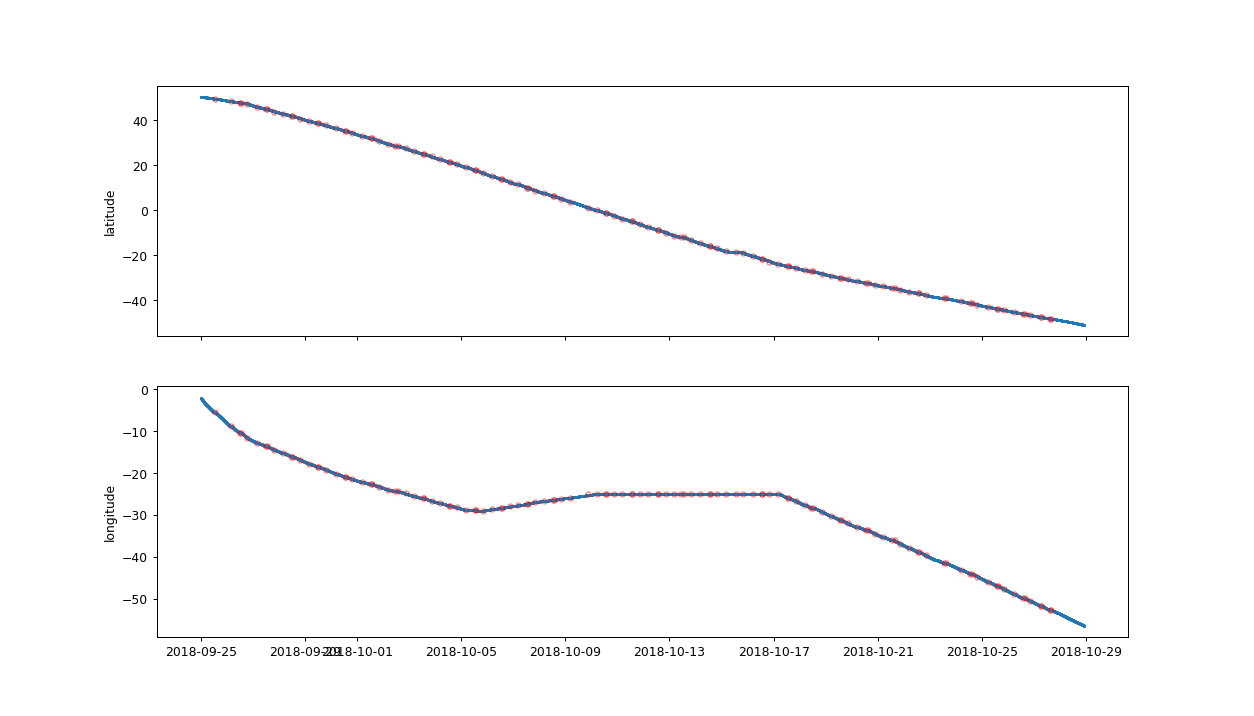

Text(0, 0.5, 'longitude')

In [45]:
# compare lat and lon of hplc and acs datasets
fig, ax = plt.subplots(2, 1, figsize = (14, 8), sharex = True)

ax[0].plot(acs.time, acs.uway_lat, '.', ms = 1, mfc = 'none')
ax[0].plot(acs.hplc_time, acs.hplc_lat, 'ro', ms = 4, mfc = 'none', alpha = 0.5)
ax[0].set_ylabel("latitude")
ax[1].plot(acs.time, acs.uway_lon, '.', ms = 1, mfc = 'none')
ax[1].plot(acs.hplc_time, acs.hplc_lon, 'ro', ms = 4, mfc = 'none', alpha = 0.5)
ax[1].set_ylabel("longitude")

In [46]:
df_CTD.keys()

Index(['Label', 'Comments_x', 'Volume ml', 'DHI no.', 'Chl_c3', 'Chlide_a',
       'Phide_a', 'Perid', 'But-fuco', 'Fuco', 'Neo', 'Pras', 'Viola',
       'Hex-fuco', 'DHI_only_Astaxanthin', 'Diadino',
       'DHI_only_Myxoxanthophyll-like', 'Allo', 'Diato', 'Zea', 'Lut',
       'DHI_only_Chl_C2_MGDG', 'Tot_Chl_b', 'DV_Chl_a', 'MV_Chl_a', 'Phytin_a',
       'SDY', 'Station', 'CTD', 'Bottle', 'lat', 'lon', 'Replica', 'Volume',
       'depth', 'Comments_y', 'Alpha-beta-Car', 'Chl_c1c2', 'Tot_Chl_a',
       'Tot_Chl_c', 'Tchl', 'PPC', 'PSC', 'PSP', 'Tcar', 'Tacc', 'Tpg', 'DP'],
      dtype='object')

In [47]:
df_hplc_surf_new = df_UND
# merge HPCL and ACS data
# see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate
# here made with dataframe instead of series

# averages duplicate values
df_hplc_surf_new = df_hplc_surf_new.groupby('time').mean() 

# create pandas series with medfilt ACS data
df_acs = pd.Series(sg.medfilt(acs.acx_chl[i2f][innan], kernel_size=31), index = acs.time.values[i2f][innan])

df_hplc_acs = pd.DataFrame({'Tot_Chl_a': df_hplc_surf_new.Tot_Chl_a, 'acx_chl': df_acs})


df_hplc_acs = df_hplc_acs.interpolate('index').reindex(df_hplc_surf_new.index)
    

    

/tmp/ipykernel_1130618/944161099.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_hplc_surf_new = df_hplc_surf_new.groupby('time').mean()


In [48]:
# compute residuals and stats
rres = df_hplc_acs.acx_chl.values / df_hplc_acs.Tot_Chl_a.values - 1

delta = np.nanmedian(rres)
sigma = prcrng(rres)
N = len(rres)

print(delta, sigma, N)

-0.08565485242716026 0.15802374145044426 58


<IPython.core.display.Javascript object>


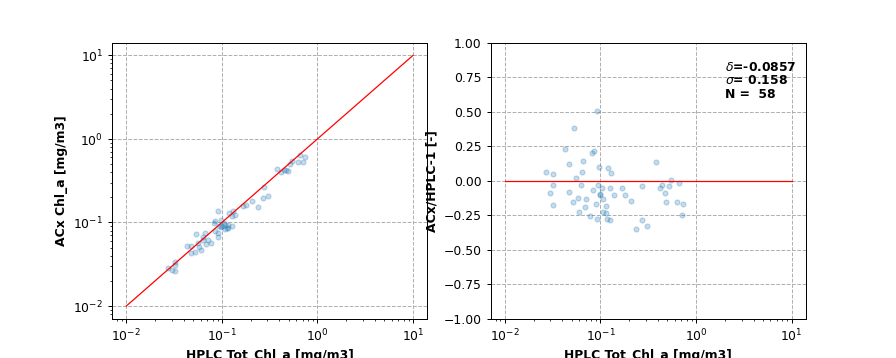

Text(2, 0.6, 'N =  58')

In [49]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acx_chl.values, 'o', ms=4, alpha=0.25)
x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACx Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('ACx/HPLC-1 [-]', fontweight='bold')
ax[1].set_ylim([-1, 1])
ax[1].text(2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
ax[1].text(2, 0.7, r'$\sigma$='+f'{sigma: 0.3}', fontweight='bold')
ax[1].text(2, 0.6, f'N = {N: 0}', fontweight='bold')


<IPython.core.display.Javascript object>


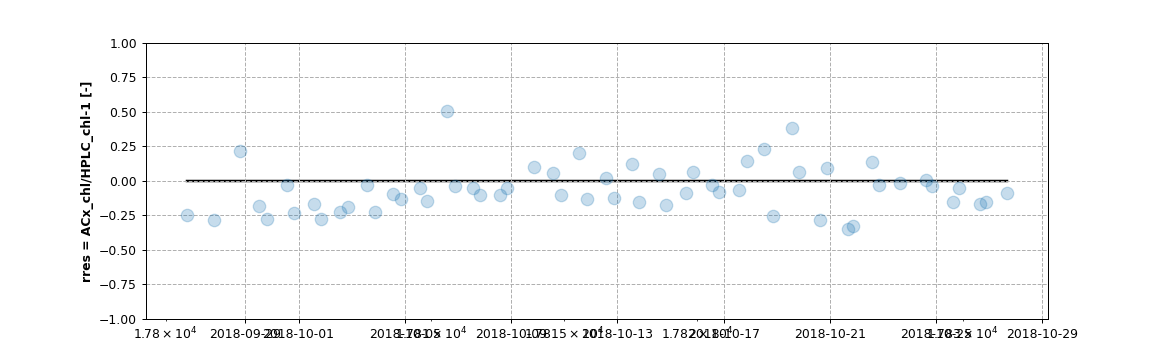

(-1.0, 1.0)

In [50]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.semilogx(df_hplc_acs.index.values, rres, 'o', ms=10, alpha=0.25, zorder=60)
ax.plot(df_hplc_acs.index.values, rres*0, 'k-', lw=2, zorder=1)
ax.set_ylabel('rres = ACx_chl/HPLC_chl-1 [-]', fontweight='bold')
ax.grid('on', ls='--')
ax.set_ylim([-1, 1])

In [51]:
ilrg_rres = np.where(abs(rres)>0.5)[0]
print(rres[ilrg_rres])
df_hplc_surf_new.iloc[ilrg_rres]

[0.5083882]


,Volume ml,DHI no.,Chl_c3,Chlide_a,Phide_a,Perid,But-fuco,Fuco,Neo,Pras,...,Tot_Chl_a,Tot_Chl_c,Tchl,PPC,PSC,PSP,Tcar,Tacc,Tpg,DP
time,,,,,,,,,,,,,,,,,,,,,
2018-10-06 13:43:00,4000.0,21.0,0.001,0.001,0.0,0.002,0.002,0.003,0.0,0.0,...,0.092,0.005,0.101,0.076,0.018,0.119,0.094,0.103,0.195,0.079


In [52]:
df_hplc_surf_new.iloc[ilrg_rres].index.dayofyear
# tt.tm_yday

Int64Index([279], dtype='int64', name='time')

In [53]:
df_hplc_surf_new.iloc[ilrg_rres].keys()

Index(['Volume ml', 'DHI no.', 'Chl_c3', 'Chlide_a', 'Phide_a', 'Perid',
       'But-fuco', 'Fuco', 'Neo', 'Pras', 'Viola', 'Hex-fuco',
       'DHI_only_Astaxanthin', 'Diadino', 'DHI_only_Myxoxanthophyll-like',
       'Allo', 'Diato', 'Zea', 'Lut', 'DHI_only_Chl_C2_MGDG', 'Tot_Chl_b',
       'DV_Chl_a', 'MV_Chl_a', 'Phytin_a', 'SDY', 'Volume', 'Alpha-beta-Car',
       'Chl_c1c2', 'Tot_Chl_a', 'Tot_Chl_c', 'Tchl', 'PPC', 'PSC', 'PSP',
       'Tcar', 'Tacc', 'Tpg', 'DP'],
      dtype='object')

In [54]:
# find dates of large rres
r = df_hplc_acs.acx_chl / df_hplc_acs.Tot_Chl_a - 1
ii = np.where(abs(r)>0.4)[0]
print(r[ii])
# iss = 2
# [df_hplc_acs.Tot_Chl_a[ii][iss], df_hplc_acs.acx_chl[ii][iss]]

time
2018-10-06 13:43:00    0.508388
dtype: float64


In [55]:
# # de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
# df_hplc_acs.acs_chl_debiased = df_hplc_acs.acs_chl*(1-delta)

In [56]:
# fit data to power law
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x**b

popt, pcov = curve_fit(func, 0.014*df_hplc_acs.acx_chl.values, df_hplc_acs.Tot_Chl_a.values)

perr = np.sqrt(np.diag(pcov)) # parameter uncertainty 

print("chl_HPLC = a * chl_ACS^b " )

print("a = " + f'{popt[0]:.1f} ' + "+/- " + f'{perr[0]:.1f}' )
print("b = " + f'{popt[1]:.3f} ' + "+/- " + f'{perr[1]:.3f}' )


chl_HPLC = a * chl_ACS^b 
a = 78.4 +/- 12.6
b = 0.999 +/- 0.031


In [57]:
# # compute resuduals and stats
# rres = df_hplc_acs.acs_chl_debiased.values/df_hplc_acs.Tot_Chl_a.values-1

# delta = np.nanmedian(rres)
# sigma = prcrng(rres)
# N = len(rres)

# print(delta, sigma, N)

In [58]:
# fig, ax = plt.subplots(1,2, figsize=(10, 4))

# ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl_debiased.values, 'o', ms=4, alpha=0.25)
# x = np.logspace(np.log10(0.01), np.log10(10), 100)
# ax[0].loglog(x, x, 'r-', lw=1)
# ax[0].grid('on', ls='--')
# ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
# ax[0].set_ylabel('ACS Chl_a [mg/m3]', fontweight='bold')

# ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
# ax[1].semilogx(x, x*0, 'r-', lw=1)
# ax[1].grid('on', ls='--')
# ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
# ax[1].set_ylabel('ACS/HPLC-1 [-]', fontweight='bold')

# ax[1].text(2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
# ax[1].text(2, 0.7, r'$\sigma$='+f'{sigma: 0.3}', fontweight='bold')
# ax[1].text(2, 0.6, f'N = {N: 0}', fontweight='bold')


In [59]:
# de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
innan = np.where(~np.isnan(acs.acx_chl[i2f]))[0]
acs['acx_chl_debiased'] = acs.acx_chl*(1-delta)
# acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
acs_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan],
                               'lon [degE]': acs.uway_lon[i2f][innan],
                               'acs_chl_debiased [mg_m3]': acs.acx_chl_debiased[i2f][innan]
                              }  ,
                      index = acs.time.values[i2f][innan])
acs_out.index.rename('date_time [UTC]', inplace = True)

In [60]:
# add attributes to acs_chl_debiased
acs.acx_chl_debiased.attrs["debiasing_equation"] = "acs.acx_chl_deiased = acs.acx_chl*(1-delta)"
acs.acx_chl_debiased.attrs["delta"] = delta
acs.acx_chl_debiased.attrs["sigma"] = sigma
acs.acx_chl_debiased.attrs["units"] = "mg/m3"
acs.acx_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acx_chl/HPLC_Tot_Chl_a-1, based on surface data"
acs.acx_chl_debiased.attrs["HPLC_Tot_chla"] = df_hplc_acs.Tot_Chl_a.values
acs.acx_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
acs.acx_chl_debiased.attrs["acx_chl"] = df_hplc_acs.acx_chl.values
acs.acx_chl_debiased.attrs["acx_chl_units"] = "mg/m3"
acs.acx_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
acs.acx_chl_debiased.attrs["match_up_dates"] = df_hplc_acs.index.format()


In [61]:
# create new filtered acs dataframe
#acs2 = acs.reset_index('time') # this is needed only for AMT29

# i2kp = np.where(  (acs.acs_ap[i2f,10][innan]>0) | (np.isreal(acs.ay440))  )[0]         # this removes ay data
#i2kp = np.where(  (acs2.acs_ap[:,10]>0)   ) [0]
# i2kp = np.where(  acs.acs_ap[i2f,10][innan]>0  )[0]         # this removes ay data
# ix = xr.DataArray(acs.time[i2f][innan][i2kp], dims=['time'])
#ix = xr.DataArray(acs2.time[i2kp], dims=['time'])
#acs_filtered = acs2.sel(time=ix)


# tjor edit: sequential version of filtering 

#step x - # filters w.r.t. i2fn (mQ interval + previous manual spike removal) and innan
ix = xr.DataArray(acs.time[i2f][innan], dims=['time']) 
acs_filtered_x = acs.sel(time = ix)
acs_filtered_x['acx_chl'].values = sg.medfilt(acs.acx_chl[i2f][innan], kernel_size=31) # apply med filter to acx chl and acx chl debiasesd 
acs_filtered_x['acx_chl_debiased'].values = sg.medfilt(acs.acx_chl_debiased[i2f][innan], kernel_size=31)

#plt.figure()
#plt.plot(np.log10(acs_filtered_x['acx_chl']))
   # Re-defined as med-filtered time series (this was previously not done)
#print(len(acs_filtered_x['acx_chl']) = sg.medfilt(acs.acx_chl[i2f][innan], kernel_size=31))

#step y - # filters w.r.t. ap (10the element) being > 0
i2kp = np.where(np.logical_or(acs_filtered_x.acs_ap[:,10] > 0,acs_filtered_x.ac9_ap[:,0] >0))[0]
iy = xr.DataArray(acs_filtered_x.time[i2kp], dims=['time']) 
acs_filtered_xy = acs_filtered_x.sel(time = iy)
#plt.plot(acs_filtered_xy['acx_chl'])

#step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs_filtered_xy.acx_chl[:] > 0)) [0]
iz = xr.DataArray(acs_filtered_xy.time[i2kp], dims=['time']) 
acs_filtered_xyz = acs_filtered_xy.sel(time = iz)
#plt.plot(acs_filtered_xy['acx_chl'])         



In [62]:
acs_filtered2 = acs_filtered_xyz
#acs_filtered2 = acs_filtered2.rename_vars({'time_': 'time'}, )

In [63]:
# plot to check                   
#iwv = np.where(acs_filtered.acs_wv==490)[0]
#fig, [ax, ax2] = plt.subplots(2,1, figsize=(13, 4), sharex=True)

#ax.semilogy(acs_filtered.time_[:], acs_filtered.acs_ap[:,iwv], 'b.', ms=1)
# ax.semilogy(acs_filtered.time_[:], sg.medfilt(x, 151), 'b.', ms=1)
#ax.semilogy(acs_filtered2.time, acs_filtered2.acs_ap[:,iwv], 'ro', ms=1, mfc='none', alpha=0.5)
#ax.grid('on')

#ax2.grid('on')

#fig, [ax, ax2, ax3] = plt.subplots(3,1, figsize=(13, 4), sharex=True)

#iwv = np.where(acs_filtered_x.acs_wv==490)[0]
#ax.semilogy(acs.time[:], acs.acs_ap[:,iwv], 'b.', ms=1)

#iwv_x = np.where(acs_filtered_x.acs_wv==490)[0]
#ax2.semilogy(acs_filtered_x.time[:], acs_filtered_x.acs_ap[:,iwv_x], 'r.', ms=1)

#iwv_y = np.where(acs_filtered_xy.acs_wv==490)[0]
#ax3.semilogy(acs_filtered_xy.time[:], acs_filtered_xy.acs_ap[:,iwv_y], 'g.', ms=1)
#ax.semilogy(acs_filtered.time[:], sg.medfilt(x, 151), 'b.', ms=1)
#ax.semilogy(acs_filtered2.time, acs_filtered2.acs_ap[:,iwv], 'ro', ms=1, mfc='none', alpha=0.5)
#ax.grid('on')


In [64]:
# save to file for Silvia
# acs_out.to_csv('AMT29_ACS_chl_debiased.csv')
acs_filtered2

<xarray.Dataset>
Dimensions:                             (time: 33331, acs_wv: 176, ac9_wv: 9,
                                         bb3_wv: 3, hplc_time: 124)
Coordinates:
  * time                                (time) datetime64[ns] 2018-09-25T21:1...
  * acs_wv                              (acs_wv) float64 400.0 402.0 ... 750.0
  * ac9_wv                              (ac9_wv) float64 412.0 440.0 ... 715.0
  * bb3_wv                              (bb3_wv) float64 470.0 532.0 700.0
  * hplc_time                           (hplc_time) datetime64[ns] 2018-09-25...
Data variables: (12/100)
    flow                                (time) float64 41.51 41.5 ... 39.81
    acs_chl                             (time) float64 0.3009 0.3043 ... nan nan
    acs_ap                              (time, acs_wv) float64 0.0152 ... nan
    acs_ap_u                            (time, acs_wv) float64 0.007118 ... nan
    acs_bp                              (time, acs_wv) float64 ...
    acs_bp_u                            (time, acs_wv) float64 ...
    ...                                  ...
    hplc_Tacc                           (hplc_time) float64 2.822 0.356 ... 0.48
    hplc_Tpg                            (hplc_time) float64 5.769 0.748 ... 0.95
    hplc_DP                             (hplc_time) float64 1.724 ... 0.321
    hplc_file                           <U25 'Results DAN_2019_012.xlsx'
    acx_chl                             (time) float64 0.2962 0.2962 ... 0.3947
    acx_chl_debiased                    (time) float64 0.3216 0.3216 ... 0.4285

In [65]:
#test for similar keys between AMT28 and AMT29 (baseline)

#load AMT29 (baseline for netcdf)
path_nc_29 = '/data/lazarev1/backup/cruise_data/AMT29/Public_Read_Only_Copy/DY110_Public/Optics_group/Processed/Underway/Step3/amt29_final_with_debiased_chl.nc'
nc_data_29 = xr.open_dataset(path_nc_29)  


#test for common and unqiue keys
keys_28 = list(acs_filtered2.keys())
keys_29 = list(nc_data_29.keys())
common_keys = set(keys_28).intersection(set(keys_29)) # keys contained in both cruises
extra_keys_28 =  set(keys_28) ^ common_keys # extra keys in AMT 28
extra_keys_29 = set(keys_29) ^ common_keys # extra keys in AMT29

print('common keys')
print(sorted(common_keys))

print('/n extra keys in amt28')
print(sorted(extra_keys_28))

# manual clean up of AMT 27 keys
#acs_filtered_xy = acs_filtered_xy.rename_vars({"uway_lon": "uway_long"})
#acs_filtered_xy = acs_filtered_xy.drop("ac9_N")
#acs_filtered_xy = acs_filtered_xy.drop("ac9_chl")

# manual clean up of AMT 28 keys
#acs_filtered2 = acs_filtered2.rename_vars({"uway_lon": "uway_long"})
#acs_filtered_xy = acs_filtered_xy.drop("ac9_N")
#acs_filtered_xy = acs_filtered_xy.drop("ac9_chl")

print('/n extra keys in amt29')
print(sorted(extra_keys_29))


common keys
['acs_N', 'acs_ap', 'acs_ap_u', 'acs_bp', 'acs_bp_u', 'acs_chl', 'acs_cp', 'acs_cp_u', 'bb3_bb02', 'bb3_bb02_err', 'bb3_bbp', 'bb3_bbp_corr', 'bb3_bbp_err', 'cstar_cp', 'cstar_cp_err', 'ctd_sal', 'ctd_sst', 'flow', 'hplc_Allo', 'hplc_Alpha-beta-Car', 'hplc_But-fuco', 'hplc_Chl_c1c2', 'hplc_Chl_c3', 'hplc_Chlide_a', 'hplc_DP', 'hplc_DV_Chl_a', 'hplc_Diadino', 'hplc_Diato', 'hplc_Fuco', 'hplc_Hex-fuco', 'hplc_Lut', 'hplc_MV_Chl_a', 'hplc_Neo', 'hplc_PPC', 'hplc_PSC', 'hplc_PSP', 'hplc_Perid', 'hplc_Phide_a', 'hplc_Phytin_a', 'hplc_Pras', 'hplc_Tacc', 'hplc_Tcar', 'hplc_Tchl', 'hplc_Tot_Chl_a', 'hplc_Tot_Chl_b', 'hplc_Tot_Chl_c', 'hplc_Tpg', 'hplc_Viola', 'hplc_Zea', 'hplc_bottle', 'hplc_depth', 'hplc_lat', 'hplc_lon', 'hplc_station', 'uway_conductivity', 'uway_flowrate', 'uway_lat', 'uway_par2', 'uway_sal', 'uway_sst', 'uway_thermosalinograph_temp', 'uway_tir1', 'uway_tir2']
/n extra keys in amt28
['ac9_N', 'ac9_ap', 'ac9_ap_u', 'ac9_bp', 'ac9_bp_u', 'ac9_chl', 'ac9_chl_adj',

In [66]:
# save updated NetCDF file

acs_filtered2.to_netcdf(DIN_acs+fn_acs[:-3]+'_with_debiased_chl.nc')
acs_filtered2.close()

<IPython.core.display.Javascript object>


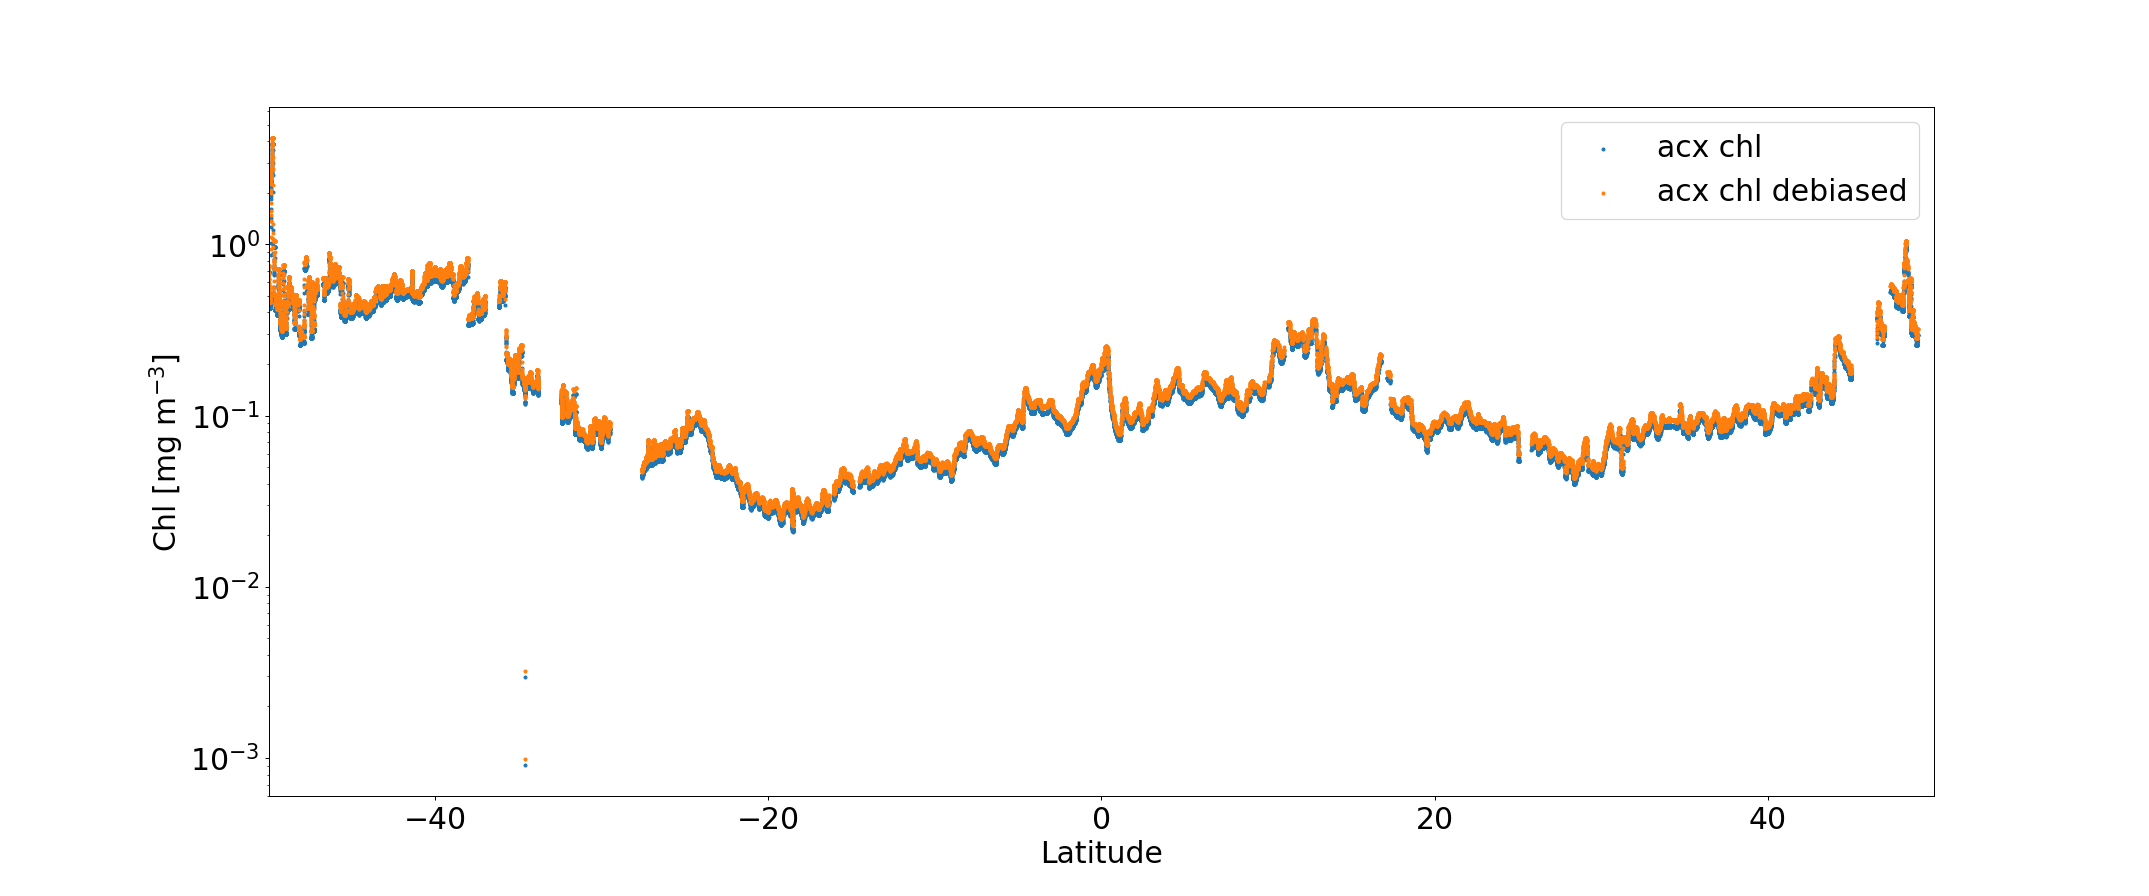

Text(0, 0.5, 'Chl [mg m$^{-3}$]')

In [67]:

# plot to show debiassing of chl
plt.figure(figsize=(24,10))
plt.rc('font', size=24)

plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['acx_chl'], s=5,label='acx chl ')
plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['acx_chl_debiased'], s=5,label='acx chl debiased')
plt.gca().set_yscale('log')
plt.legend()
plt.xlabel('Latitude')
plt.xlim(-50,50)
plt.ylabel('Chl [mg m$^{-3}$]')
    

<IPython.core.display.Javascript object>


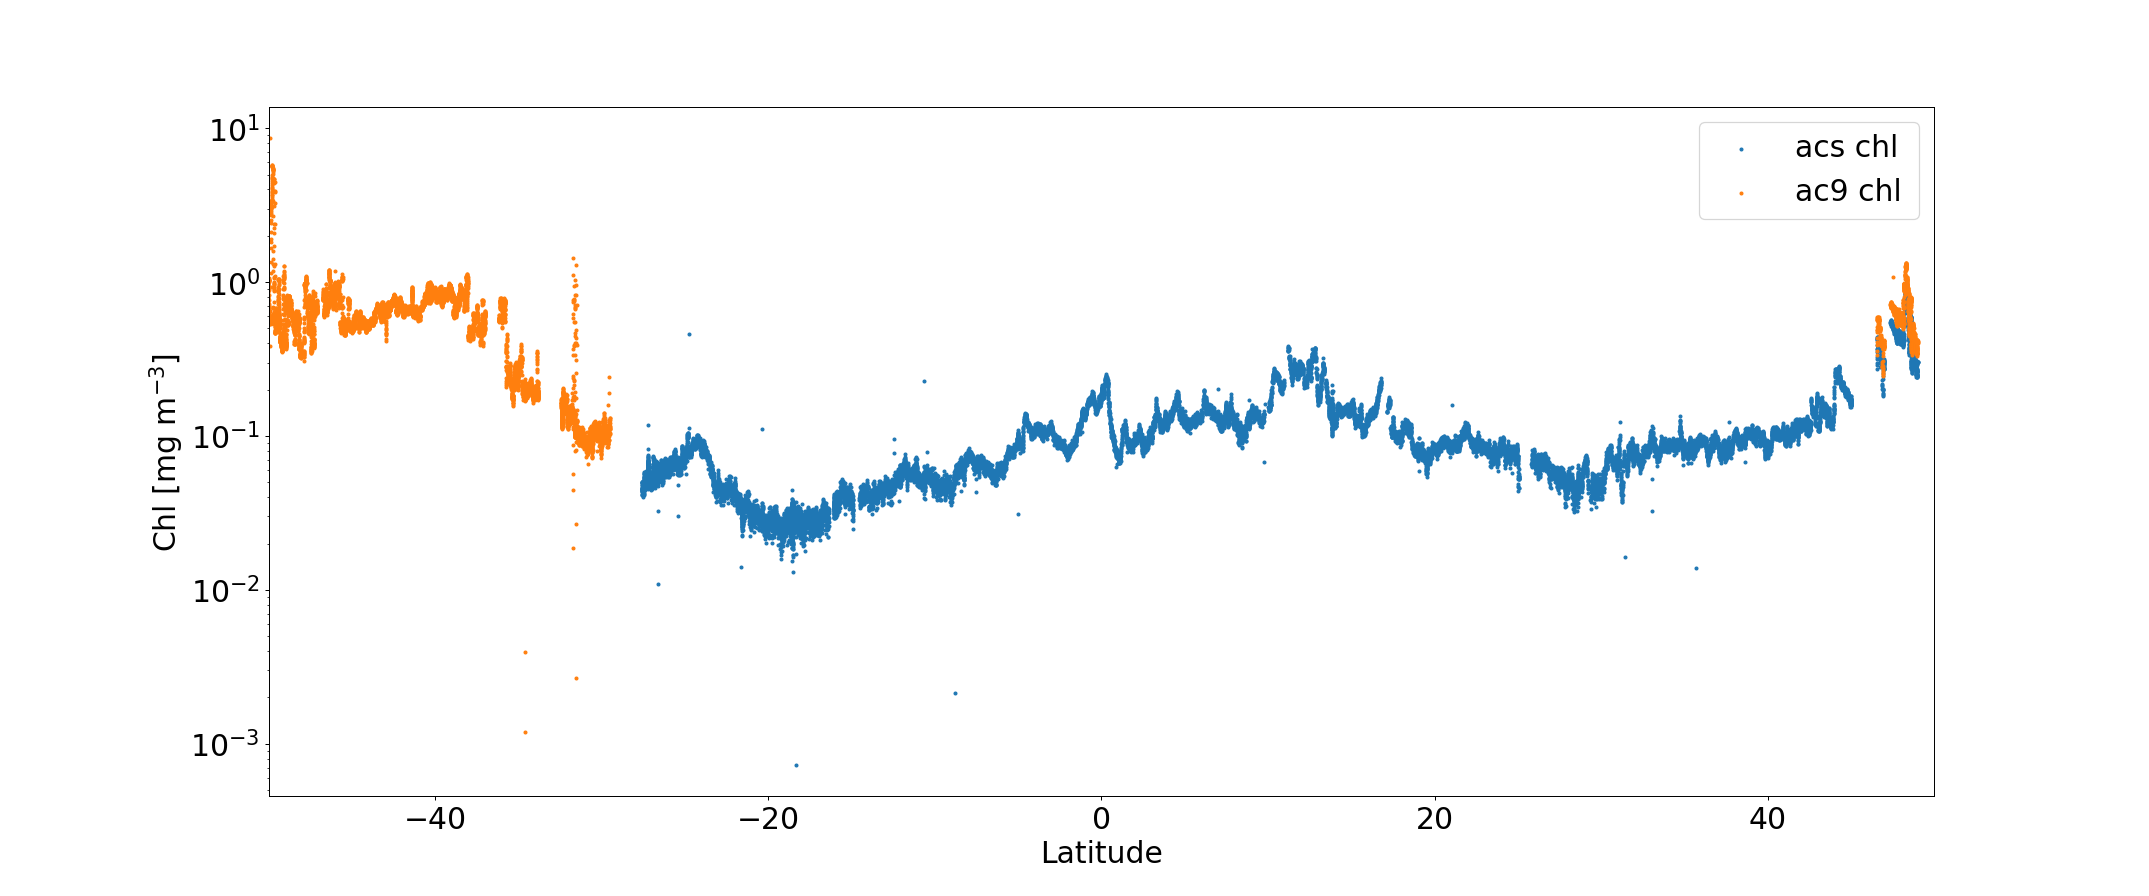

Text(0, 0.5, 'Chl [mg m$^{-3}$]')

In [68]:
# plot to show acs and ac9 chl separately
plt.figure(figsize=(24,10))
plt.rc('font', size=24)

plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['acs_chl'], s=5,label='acs chl ')
plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['ac9_chl'], s=5,label='ac9 chl')
plt.gca().set_yscale('log')
plt.legend()
plt.xlabel('Latitude')
plt.xlim(-50,50)
plt.ylabel('Chl [mg m$^{-3}$]')

In [69]:
plt.i
plt.plot(acs_filtered2['acs_chl'])

plt.plot(acs_filtered2['ac9_chl'])

AttributeError: module 'matplotlib.pyplot' has no attribute 'i'

In [ ]:
list(acs_filtered2.keys())